# CMSE 202 Homework 4 (Individual)

## Using SVM and PCA to predict the outcome of chess games

### Goals for this homework assignment

By the end of this assignment, you should be able to:

* Use `git` to track your work and turn in your assignment
* Read and impute data to prepare it for modeling
* Build, fit, and evaluate an SVC model of data
* Use PCA to reduce the number of important features
* Build, fit, and evaluate an SVC model of pca transformed data
* Systematically investigate the effects of the number of components on an SVC model of data


### Assignment instructions:

Work through the following assignment, making sure to follow all of the directions and answer all of the questions.

There are 25 points possible on this assignment. Point values for each part are included in the section headers.

This assignment is due at 11:59 pm on Friday, November 13th. It should be pushed to your repo (See Part 1). 

In [3]:
## Our imports
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sea
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

---
## 1. Adding notebook to your turn-in repository

Like you did for Homework 3, you're going to add it to the CMSE202 repository you created in class so that you can track your progress on the assignment and preserve the final version that you turn in. In order to do this you need to:

* Navigate to your /CMSE202/repos repository and create a new directory called hw-04.
* Move this notebook into that new directory in your repository, then add it and commit it to your repository.
   * Finally, to test that everything is working, "git push" the file so that it ends up in your GitHub repository.

Important: Make sure you've added your TA as a collaborators to your respository with "Read" access so that we can see your assignment. (*If you did this for Homework 3, you do not need to do it again*)

* Section 001: tuethan
* Section 002: Luis-Polanco
* Section 003: DavidRimel

Also important: Make sure that the version of this notebook that you are working on is the same one that you just added to your repository! If you are working on a different copy of the notebook, none of your changes will be tracked.

If everything went as intended, the file should now show up on your GitHub account CMSE202 repository under the hw-04 directory that you just created. Periodically, you'll be asked to commit your changes to the repository and push them to the remote GitHub location. Of course, you can always commit your changes more often than that, if you wish. It can be good to get into a habit of committing your changes any time you make a significant modification, or when you stop working on the project for a bit.

---
## 2. Chess Game Data

The data you will work are configurations of a chess end game. It assumes that a pawn is one move away from ["queening"](https://en.wikipedia.org/wiki/Promotion_(chess)) and 
the other pieces can be moved to perform different offensive or defensive actions. For each of the 36 potential features, there are several potential values for each (entries in a given column). **The details of the data matter a bit less for our purposes, but we are attempting to predict the won/loss by a given side.** If you really want to know about the data, you can look into a [classic text on Artificial Intelligence by Shapiro](https://www.amazon.com/Encyclopedia-Artificial-Intelligence-Stuart-Shapiro/dp/0471807486).

You will first do this with a full model, then investigate how well the model works after a PCA has been done on the data.

### 2.1 Read in the data

First you need to read in the data from `kr-vs-kp.data`. You can look at `kr-vs-kp.names` to see how the data is structured. But we give you the code for the column naming as there are so many features and they are unlabeled in the `.data` file.

```cols = ["bkblk","bknwy","bkon8","bkona","bkspr","bkxbq","bkxcr","bkxwp","blxwp","bxqsq","cntxt","dsopp","dwipd",
 "hdchk","katri","mulch","qxmsq","r2ar8","reskd","reskr","rimmx","rkxwp","rxmsq","simpl","skach","skewr",
 "skrxp","spcop","stlmt","thrsk","wkcti","wkna8","wknck","wkovl","wkpos","wtoeg","won"]```
 
<font size=8 color="#009600">&#9998;</font> Do this - Read in the data from `kr-vs-kp.data` using the columns listed above. Print the `.head()` of the dataframe.

In [4]:
## your code here
data = pd.read_fwf("kr-vs-kp.data",delimiter=',')
data.set_axis(["bkblk","bknwy","bkon8","bkona","bkspr","bkxbq","bkxcr","bkxwp","blxwp","bxqsq","cntxt","dsopp","dwipd",
 "hdchk","katri","mulch","qxmsq","r2ar8","reskd","reskr","rimmx","rkxwp","rxmsq","simpl","skach","skewr",
 "skrxp","spcop","stlmt","thrsk","wkcti","wkna8","wknck","wkovl","wkpos","wtoeg","won"],axis=1,inplace=True)
data = data.drop([3195,3196],axis=0)
data.head()

,bkblk,bknwy,bkon8,bkona,bkspr,bkxbq,bkxcr,bkxwp,blxwp,bxqsq,...,spcop,stlmt,thrsk,wkcti,wkna8,wknck,wkovl,wkpos,wtoeg,won
0,f,f,f,f,t,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
1,f,f,f,f,t,f,t,f,f,f,...,f,f,f,f,f,f,t,t,n,won
2,f,f,f,f,f,f,f,f,t,f,...,f,f,f,f,f,f,t,t,n,won
3,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
4,f,f,f,f,f,f,f,f,f,f,...,f,f,t,f,f,f,t,t,n,won


### 2.2 Imputing the data

There are no missing data in this data file, but there are some other issues. 

When you print the head of this data set, you probably noticed that all the features and labels are strings. We need to replace them with numerical values for modeling. For the `won` column replace winning with a 1 and losing with a 0. For the other columns, there are seven strings. Replace them using the following table:

| raw data | replaced |
| -------- | -------- |
| f | 1 |
| l | 2 |
| n | 3 |
| t | 4 |
| w | 5 |
| b | 6 |
| g | 7 |

**Note:** this choice really matters and for the models we have learned can really influence the results of our model. We do this because we need to for the model, but we haven't critically thought about the mapping that makes the most sense. There are other models (e.g., [tree-based alogrithms](https://en.wikipedia.org/wiki/Random_forest)) that can handle these categorical data without this mapping.

<font size=8 color="#009600">&#9998;</font> Do this - Replace the entries in the columns as indicated above. Print the `.head()` of the dataframe to show you have succesfull done so.

In [5]:
## your code here
data['won'] = data['won'].replace('won',1)
data['won'] = data['won'].replace('now',0)
data = data.replace('f',1)
data = data.replace('l',2)
data = data.replace('n',3)
data = data.replace('t',4)
data = data.replace('w',5)
data = data.replace('b',6)
data = data.replace('g',7)
data

,bkblk,bknwy,bkon8,bkona,bkspr,bkxbq,bkxcr,bkxwp,blxwp,bxqsq,...,spcop,stlmt,thrsk,wkcti,wkna8,wknck,wkovl,wkpos,wtoeg,won
0,1,1,1,1,4,1,1,1,1,1,...,1,1,1,1,1,1,4,4,3,1
1,1,1,1,1,4,1,4,1,1,1,...,1,1,1,1,1,1,4,4,3,1
2,1,1,1,1,1,1,1,1,4,1,...,1,1,1,1,1,1,4,4,3,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,4,4,3,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,4,1,1,1,4,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,4,1,1,1,1,1,4,1,1,1,...,1,4,1,1,4,1,4,1,3,0
3191,4,1,1,1,1,1,4,1,1,1,...,1,4,1,1,4,1,4,1,3,0
3192,4,1,1,1,1,1,4,1,1,1,...,1,4,1,1,4,1,4,1,3,0
3193,4,1,4,1,1,1,4,1,1,1,...,1,4,1,1,4,1,1,1,3,0


### 2.3 Separate features and class labels

As we have seen in our analyses using `sklearn` it is advantageous to separate our dataframes into `features` and `labels` for the analysis we are intending to do.

<font size=8 color="#009600">&#9998;</font> Do this - Separate the data frame into two: a features dataframe and a labels dataframe.

In [6]:
## your code here
features = data.drop(['won'],axis=1)
labels = data['won']

**Question:** How balanced is your outcome variable? Why does it matter for the outcome to be balanced?

In [7]:
won = len(data[data['won']==0])
loss = len(data[data['won']==1])

In [8]:
print(f'Number of outcomes as wins: {won}')
print(f'Number of outcomes as losses:{loss}')

Number of outcomes as wins: 1527
Number of outcomes as losses:1668


<font size=8 color="#009600">&#9998;</font> We have almost 50/50 outcome for our variables. The reason why we would not want a great disparity in outcomes is due to the training bias we would be creating in our machine when it comes time to create a predictor.

---
## 3. Building an SVC model

For this classification problem, we will use an support vector machine. As you learned in the midterm review, we could easily replace this with any `sklearn` classifier we choose. We will use a linear kernel.

### 3.1 Splitting the data

<font size=8 color="#009600">&#9998;</font> Do this - Split your data into a training and testing set with a train size representing 75% of your data. Print the lengths to show you have the right number of entries.

In [9]:
## your code here
train_labels, test_labels, train_vectors, test_vectors = train_test_split(labels , features, test_size = .25, train_size = .75)
print(f'Length of full list is: {len(features)} entries (which 75% of that ~{round(len(features)*.75,0)} entries).')
print(f'The length of the training set is: {len(train_vectors)} entries')

Length of full list is: 3195 entries (which 75% of that ~2396.0 entries).
The length of the training set is: 2396 entries


### 3.2 Modeling the data and evaluting the fit

As you have done this a number of times, we ask you to do most of the analysis in one cell.

<font size=8 color="#009600">&#9998;</font> Do this - Build a linear SVC model (`C=100`), fit it to the training set, use the test features to predict the outcomes. Evaluate the fit using the confusion matrix and classification report.

 **Note:** You should look at the documentation on the confusion matrix because the way `sklearn` outputs false positives and false negatives is different from what most images on the web indicate.

In [8]:
#make some temporary variables so you can change this easily
SVM = svm.SVC(kernel='linear',C=100)
SVM.fit(train_vectors,train_labels)
predict_SVM = SVM.predict(test_vectors)

print(confusion_matrix(test_labels, predict_SVM, labels=range(2)))
print(SVM.score(test_vectors,test_labels))

[[377   9]
 [ 18 395]]
0.9662077596996246


**Question:** How accurate is your model? What eveidence are you using to determine that? How many false positives and false negatives does it predict?

<font size=8 color="#009600">&#9998;</font> My model is ~95.6% accurate, and has 14 false positives and 21 false negatives.

---
## 4. Finding and using the best hyperparameters

We have fit one model and determined it's performance, but is it the best model? We can use `GridSearchCV` to find the best model (given our choices of parameters). Once we do that, we will use that best model going forward. **Note:** you would typically rerun this grid search in a production environment to continue to verify the best model, but we are not for the sake of speed.

### 4.1 Grid search

<font size=8 color="#009600">&#9998;</font> Do this - Using the following parameters (`C` = 1, 10, 100, 1000 and `gamma` = 1e-4, 1e-3, 0.01, 0.1) for both a `linear` and `rbf` kernel use `GridSearchCV` with the `SVC()` model to find the best fit parameters. Print the "best estimators".

In [ ]:
## your code here

#make some temporary variables so you can change this easily
tmp_vectors = train_vectors
tmp_labels = train_labels

print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
# make a classifier by searching over a classifier and the parameter grid
clf = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), param_grid)
# we have a "good" classifier (according to GridSearchCV), how's it look
clf = clf.fit(tmp_vectors, tmp_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set


### 4.2 Evaluating the best fit model

Now that we have found the "best estimators", let's determine how good the fit is.

<font size=8 color="#009600">&#9998;</font> I let my computer sit for 3 hours and it would not complete the code above, as in it wouldn't even complete and give me an error code at the very least.

**Note:** You should look at the documentation on the confusion matrix because the way `sklearn` outputs false positives and false negatives is different from what most images on the web indicate.

In [24]:
## your code here
# due to not finding the "best estimator" I couldn't change any of the values in SVC to get a better estamite but to show 
# I at least had an idea of what is going on I set up the code below minus the actual "best estimator"

# I would've put the best estimator values in the SVC parenthasese and then ran the rest
# If you have the best estimator and put it in all the code below should run still
best_SVM = svm.SVC(kernel='linear', C=100)

best_SVM.fit(train_vectors,train_labels)
predict_best_SVM = best_SVM.predict(test_vectors)

print(confusion_matrix(test_labels, predict_best_SVM, labels=range(2)))
print(best_SVM.score(test_vectors,test_labels))

[[367  23]
 [  9 400]]
0.9599499374217773


**Question:** How accurate is this best model? What evidence are you using to determine that? How many false positives and false negatives does it predict?

<font size=8 color="#009600">&#9998;</font> I could not see the best estimator so my answer is the same as 3.2 with what I ran this time.

---
## 5. Using Principal Components

The full model uses 36 features to predict the results. And you likely found that the model is incredibly accurate. But in some cases, we might have even more features (which means much more computational time), and we might not need nearly the level of accuracy we can achieve with the full data set. So, we will see how close we can get with fewer features. But instead of simply removing features, we will use a PCA to determine the featurse that contribute the most the model (through their accounted variance) and use those to build our SVC model.

### 5.1 Building a PCA

We will start with a small number of components (say, 4) to see how well we can predict the outcomes of the games.

<font size=8 color="#009600">&#9998;</font> Do this - Using `PCA()`, fit a pca to your training features with 4 components. Transform both the test and training features using this pca. Plot the `explained_variance_` versus component number.

In [30]:
## your code here
#Set up the pca object with the number of compoents we want to find
pca = PCA(n_components= 4, whiten=True)
pca.fit(train_vectors)
#Transform the data to the pca model.
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)
# Getting the explained varience
variance = round(np.mean(pca.explained_variance_ratio_),2)
print(f' The mean variance for 34 components is: {variance}.')


 The mean variance for 34 components is: 0.11.


**Question:** What is the total explained variance captured by this PCA (we will use this later, just quote the number)? How well do you think a model with this many featuers will perform? Why?

<font size=8 color="#009600">&#9998;</font> Answer here.

### 5.2 Fit and Evaluate an SVC model

Using the pca transformed features, we will train and test an SVC model using the "best estimators".

<font size=8 color="#009600">&#9998;</font> Do this - Using the pca transformed training data, build and train an SVC model. Predict the classes using the pca transformed test data. Evaluate the model using the classfication report, and the confusion matrix.

In [23]:
## your code here
pca_SVM = svm.SVC(kernel='linear',C=100)
pca_SVM.fit(pca_train_vectors, train_labels)

predict_pca_SVM = pca_SVM.predict(pca_test_vectors)

print(confusion_matrix(test_labels, predict_pca_SVM, labels=range(2)))
print(pca_SVM.score(pca_test_vectors,test_labels))


[[172 218]
 [109 300]]
0.590738423028786


**Question:** How accurate is this model? What evidence are you using to determine that? How many false positives and false negatives does it predict? How does it compare to the full model?

<font size=8 color="#009600">&#9998;</font> This model is straight garbage, both the confusion matrix and the accuracy score shows that is just barely over the threshold of straight guessing. We have 218 fp and 109 fn, which is way worse in comparision to the full model.

### 5.3 Repeat your analysis with more components

You probably found that the model with 4 features didn't work so well. What if we increase the number of components (say to 30, which is still 6 fewer than the full data set). What happens now?

<font size=8 color="#009600">&#9998;</font> Do this - Repeat your analysis from 5.1 and 5.2 using 30 components instead.

In [29]:
## your code here
#Set up the pca object with the number of compoents we want to find
pca = PCA(n_components= 30, whiten=True)
pca.fit(train_vectors)
#Transform the data to the pca model.
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)
pca_SVM = svm.SVC(kernel='linear',C=100)
pca_SVM.fit(pca_train_vectors, train_labels)
variance = round(np.mean(pca.explained_variance_ratio_),2)
print(f' The mean variance for 30 components is: {variance}.')

predict_pca_SVM = pca_SVM.predict(pca_test_vectors)

print(confusion_matrix(test_labels, predict_pca_SVM, labels=range(2)))
print(pca_SVM.score(pca_test_vectors,test_labels))


 The mean variance for 30 components is: 0.03.
[[360  30]
 [ 10 399]]
0.9499374217772215


**Question:** What is the total explained variance captured by this PCA? How accurate is this model? What evidence are you using to determine that? How many false positives and false negatives does it predict? How does it compare to the 4 component model? To the full model?

<font size=8 color="#009600">&#9998;</font> The mean total explained varience is .03 which is a lot less deviation than 4 components had. This model is ~94% accurate shown by the accuracy score. The model holds 30 fp and 10 fn, making it way better than the 4 component model and very similar to the full model albeit not identical as it is still a little worse (not by much though).

---
## 6. How well does a PCA work?

Clearly, the number of components we use in our PCA matters. Let's investigate how they matter by systematically building a model for any number of selected components.

### 6.1 Accuracy vs. Components

We will do this by writing a function that creates the PCA, the SVC model, fits the training data, predict the labels using test data, and returns the accuracy scores and the explained variance. So your function will take as input:
* the number of components
* the training features
* the test features
* the training labels
* the test labels
and it will return the accuracy scores for an SVC model fit to pca transformed features and the total explained variance.

<font size=8 color="#009600">&#9998;</font> Do this - Create this function, which you will use in the next section.

In [49]:
## your code here
def Model_Finder(component,train_features, test_features, train_labels, test_labels):

    pca = PCA(n_components= component, whiten=True)
    pca.fit(train_vectors,train_labels)
    #Transform the data to the pca model.
    pca_train_vectors = pca.transform(train_vectors)
    pca_test_vectors = pca.transform(test_vectors)
    pca_SVM = svm.SVC(kernel='linear',C=100)
    pca_SVM.fit(pca_train_vectors, train_labels)
    
    accuracy = pca_SVM.score(pca_test_vectors,test_labels)
    variance = round(np.mean(pca.explained_variance_ratio_),2)

    
    accuracy = pca_SVM.score(pca_test_vectors,test_labels)
    variance = round(np.mean(pca.explained_variance_ratio_),2)
    return accuracy, variance

In [50]:
    component = 5
    pca = PCA(n_components= component, whiten=True)
    pca.fit(train_vectors,train_labels)
    #Transform the data to the pca model.
    pca_train_vectors = pca.transform(train_vectors)
    pca_test_vectors = pca.transform(test_vectors)
    pca_SVM = svm.SVC(kernel='linear',C=100)
    pca_SVM.fit(pca_train_vectors, train_labels)
    
    accuracy = pca_SVM.score(pca_test_vectors,test_labels)
    variance = round(np.mean(pca.explained_variance_ratio_),2)
    print(accuracy,variance)

0.7008760951188986 0.1


### 6.2 Compute accuracies

Now that you have created a function that returns the accuracy for a given number of components, we will use that to plot the how the accuracy of your SVC model changes when we increase the number of components used in the PCA.

<font size=8 color="#009600">&#9998;</font> Do this - For 1 to 36 components, use your function above to compute and store (as a list) the accuracy of your models.

In [56]:
## your code here
components = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
accuracy_list =[]
variance_list = []
accuracy, variance = Model_Finder(1, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(2, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(3, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(4, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(5, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(6, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(7, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(8, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(9, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(10, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(11, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(12, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(13, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(14, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(15, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(16, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(17, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(18, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(19, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(20, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(21, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(22, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(23, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(24, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(25, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(26, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(27, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(28, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(29, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(30, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(31, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(32, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(33, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(34, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(35, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)
accuracy, variance = Model_Finder(36, train_vectors, test_vectors , train_labels, test_labels )
accuracy_list.append(accuracy)
variance_list.append(variance)

### 6.3 Plot accuracy vs number of components

Now that we have those numbers, it makes sense to look at the accuracy vs components.

<font size=8 color="#009600">&#9998;</font> Do this - Plot the accuracy vs components.

Text(0.5, 1.0, 'Component vs. Accuracy')

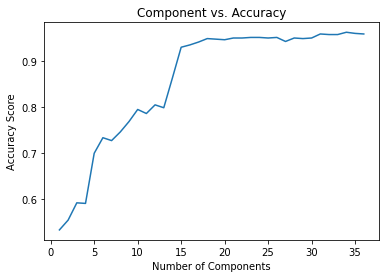

In [57]:
## your code here
plt.plot(components, accuracy_list)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy Score')
plt.title('Component vs. Accuracy')

**Question:** Where does it seem like we have diminishing returns, that is, no major increase in accuracy as we add additional components to the PCA?

<font size=8 color="#009600">&#9998;</font> Around 15ish components.

### 6.4 Plot total explained variance vs number of components

<font size=8 color="#009600">&#9998;</font> Do this - Plot the total explained variance vs components. 

Text(0.5, 1.0, 'Component vs. Variance')

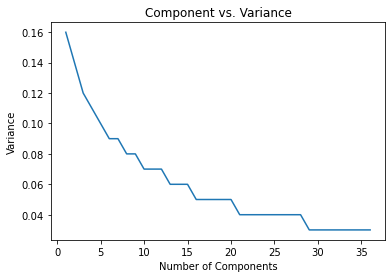

In [59]:
## your code here
plt.plot(components, variance_list)
plt.xlabel('Number of Components')
plt.ylabel('Variance')
plt.title('Component vs. Variance')

**Question:** Where does it seem like we have diminishing returns, that is, no major increase in explained variance as we add additional components to the PCA? How does that number of components compare to the diminishing returns for accuracy?

<font size=8 color="#009600">&#9998;</font> Its subjectable, but I would say around 15, 20 or 30 could be good spots due to the step like pattern we are getting. It all dependson how nitpicky you want to get with it honestly. Well it works perfect if you do decide to go with 15, however if you decide to go with the others its not as good of a fit.

---
## 7. Assignment wrap-up¶
Please fill out the form that appears when you run the code below. **You must completely fill this out in order to receive credit for the assignment!**

In [60]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://docs.google.com/forms/d/e/1FAIpQLSc0IBD2mdn4TcRyi-KNXVtS3aEg6U4mOFq2MOciLQyEP4bg1w/viewform?usp=sf_link" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

### Congratulations, you're done!
Submit this assignment by uploading it to the course Desire2Learn web page. Go to the "Homework Assignments" folder, find the dropbox link for Homework 4, and upload your notebook.